# Entrenamos con XGBoost Model

* Ampliamos filas reduciendo columnas con los lags 4,12,y 24.
* Entrenamos el modelos aplicando GridSearchCV para buscar la mejor combinación de hiperparámetros

In [135]:
import sys
from pathlib import Path

# Añade src al path para importar los módulos
sys.path.append(str(Path().resolve().parent / 'src'))


In [136]:
import pandas as pd
from paths import PROCESSED_DIR

df = pd.read_parquet(PROCESSED_DIR / 'ts_df_bolleria_20250803.parquet')
df

,base_imponible,is_summer_peak,is_easter,week_start,base_imponible_lag1,base_imponible_lag2,base_imponible_lag3,base_imponible_lag52,base_imponible_next1
0,597.65,0,0,2024-01-15,572.51,534.79,563.18,825.11,680.30
1,680.30,0,0,2024-01-22,597.65,572.51,534.79,658.40,603.99
2,603.99,0,0,2024-01-29,680.30,597.65,572.51,741.40,600.14
3,600.14,0,0,2024-02-05,603.99,680.30,597.65,653.64,689.32
4,689.32,0,0,2024-02-12,600.14,603.99,680.30,680.46,627.76
...,...,...,...,...,...,...,...,...,...
68,756.42,0,0,2025-05-19,810.97,842.62,891.38,828.30,802.16
69,802.16,0,0,2025-05-26,756.42,810.97,842.62,854.34,881.72
70,881.72,0,0,2025-06-02,802.16,756.42,810.97,782.38,1015.97
71,1015.97,0,0,2025-06-09,881.72,802.16,756.42,708.74,1014.76


In [137]:
from data_split import train_test_split
from datetime import datetime

# Realiza el split usando la fecha de corte adecuada y el target
X_train, y_train, X_test, y_test = train_test_split(
    df,
    split_date=datetime(2025, 3, 3),  # Ajusta la fecha si es necesario
    target='base_imponible'
)

In [138]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Elimina la columna "week_start" si existe en X_train y X_test
if 'week_start' in X_train.columns:
    X_train = X_train.drop(columns=['week_start'])
if 'week_start' in X_test.columns:
    X_test = X_test.drop(columns=['week_start'])

# Baseline con XGBoost
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42)

# Espacio de búsqueda para hiperparámetros
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
# Timeseries split para validación cruzada
tscv = TimeSeriesSplit(n_splits=5)

# GridSearchCV para encontrar los mejores hiperparámetros
grid_search = GridSearchCV(
    xgb_model,
    param_grid,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    n_jobs=-1,
    verbose=1
)   

print('⏳ Iniciando ajuste de hiperparámetros con GridSearchCV...')
# Entrenamos el modelo
grid_search.fit(X_train, y_train)
print('✅ Ajuste de hiperparámetros finalizado.')

# Resultados del grid search
best_params = grid_search.best_params_
best_score = -grid_search.best_score_





⏳ Iniciando ajuste de hiperparámetros con GridSearchCV...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
✅ Ajuste de hiperparámetros finalizado.


In [139]:
print(f"Mejores hiperparámetros: {best_params}")
print(f"Mejor puntuación (MAE negativo): {best_score}")

Mejores hiperparámetros: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Mejor puntuación (MAE negativo): 230.18808924696177


In [140]:
# Evaluación en test y guardado del mejor modelo
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import joblib
from paths import MODELS_DIR

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE en test: {mae:.2f}, RMSE en test: {rmse:.2f}, MAPE en test: {mape:.2F}, R2 en test: {r2:.2f}")



MAE en test: 59.83, RMSE en test: 85.19, MAPE en test: 0.08, R2 en test: 0.86


In [141]:
import joblib
from paths import MODELS_DIR
import os

# Guardamos el mejor modelo
joblib.dump(best_model, MODELS_DIR / 'xgboost_2.pkl')

['C:\\Workspace\\mlops_fleca_project\\models\\xgboost_2.pkl']

--- Modelo base (sin ajuste) ---
MAE: 74.50, RMSE: 100.32, MAPE: 0.10, R2: 0.80

--- Mejor modelo (GridSearchCV) ---
MAE: 59.83, RMSE: 85.19, MAPE: 0.08, R2: 0.86


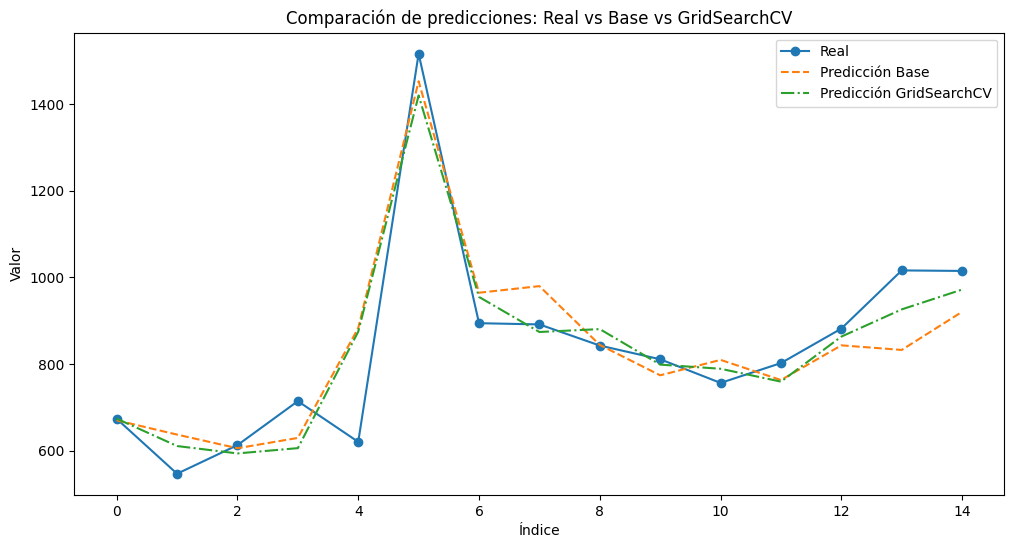

In [142]:
# Comparación de resultados: modelo base vs modelo ajustado por GridSearchCV
import matplotlib.pyplot as plt
import numpy as np

# Entrena el modelo base (sin ajuste de hiperparámetros)
xgb_model.fit(X_train, y_train)

# Predicción con modelo base (sin ajuste de hiperparámetros)
y_pred_base = xgb_model.predict(X_test)
mae_base = mean_absolute_error(y_test, y_pred_base)
rmse_base = mean_squared_error(y_test, y_pred_base) ** 0.5
mape_base = mean_absolute_percentage_error(y_test, y_pred_base)
r2_base = r2_score(y_test, y_pred_base)

print('--- Modelo base (sin ajuste) ---')
print(f'MAE: {mae_base:.2f}, RMSE: {rmse_base:.2f}, MAPE: {mape_base:.2F}, R2: {r2_base:.2f}')

# Predicción con mejor modelo ajustado
y_pred_grid = best_model.predict(X_test)
mae_grid = mean_absolute_error(y_test, y_pred_grid)
rmse_grid = mean_squared_error(y_test, y_pred_grid) ** 0.5
mape_grid = mean_absolute_percentage_error(y_test, y_pred_grid)
r2_grid = r2_score(y_test, y_pred_grid)

print('\n--- Mejor modelo (GridSearchCV) ---')
print(f'MAE: {mae_grid:.2f}, RMSE: {rmse_grid:.2f}, MAPE: {mape_grid:.2F}, R2: {r2_grid:.2f}')

# Gráfica de comparación de predicciones
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='Real', marker='o')
plt.plot(y_pred_base, label='Predicción Base', linestyle='--')
plt.plot(y_pred_grid, label='Predicción GridSearchCV', linestyle='-.')
plt.title('Comparación de predicciones: Real vs Base vs GridSearchCV')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.show()